In [ ]:
import numpy as np
from gal_goku import hmf as halo_mass_func

for fid in ['HF', 'L2', 'L1']:
    base_dir = f'/scratch/06536/qezlou/Goku/FOF/{fid}'
    save_File = f'/scratch/06536/qezlou/Goku/processed_data/HMF/{fid}_hmfs.hdf5'
    hmf = halo_mass_func.Hmf()
    hmf.get_all_fof_hmfs(base_dir=base_dir, save_file=save_File)
    print(f'fid = {fid} is done!')

[ 000000.00 ]   0: 01-09 14:49  Hmf             INFO     Logger initialized at level: 20
[ 000000.00 ]   0: 01-09 14:49  Hmf             INFO     MPI_COMM_WORLD | size = 1 -- Nbkit COMM | size = 1
[ 000000.00 ]   0: 01-09 14:49  Hmf             INFO     base_dir = /scratch/06536/qezlou/Goku/FOF/HF | number of sims = 21, z = 2.5
[ 000000.04 ]   0: 01-09 14:49  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000000.76 ]   0: 01-09 14:49  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}


2025-01-07 18:00:47.678962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 18:00:47.771154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-07 18:00:47.771176: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-07 18:00:47.797812: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 18:00:48.239486: W tensorflow/stream_executor/platform/de

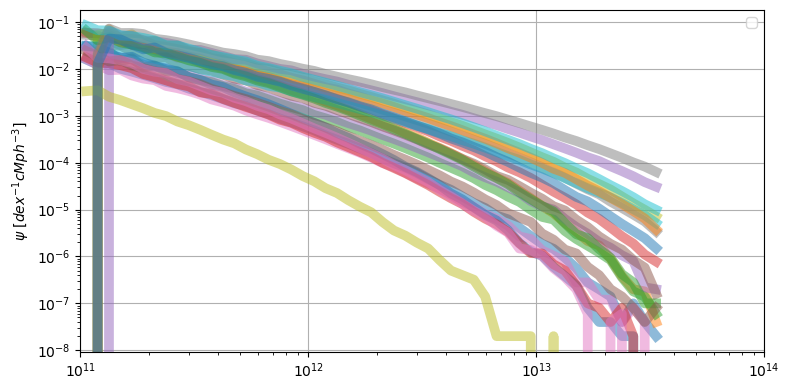

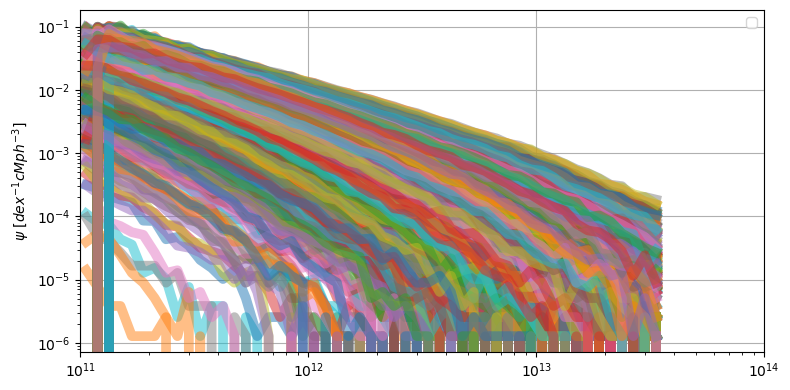

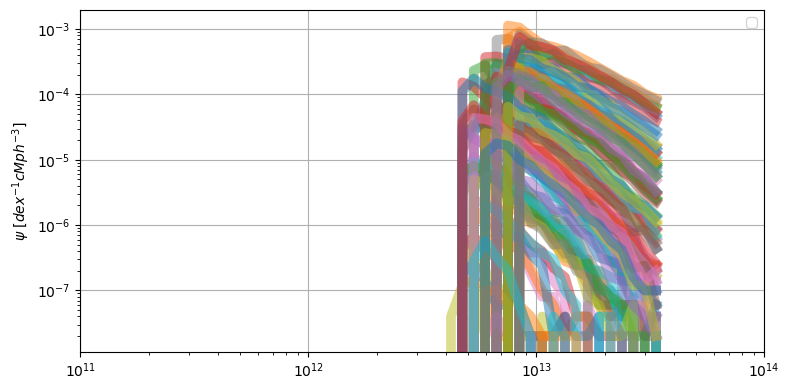

In [1]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.sim_hmf(fids=['HF'])
plt_hmf.sim_hmf(fids=['L2'])
plt_hmf.sim_hmf(fids=['L1'])

01/09/2025 02:17:14 PM Found 21 common pairs
01/09/2025 02:17:14 PM Found 21 common pairs
01/09/2025 02:17:14 PM Found 21 common pairs
01/09/2025 02:17:14 PM Found 21 common pairs
01/09/2025 02:17:14 PM Found 21 common pairs
01/09/2025 02:17:14 PM Found 21 common pairs


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
01/09/2025 02:17:15 PM Found 9 common pairs
01/09/2025 02:17:15 PM Found 9 common pairs
01/09/2025 02:17:15 PM Found 9 common pairs
01/09/2025 02:17:15 PM Found 9 common pairs
01/09/2025 02:17:15 PM Found 9 common pairs
01/09/2025 02:17:15 PM Found 9 common pairs
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


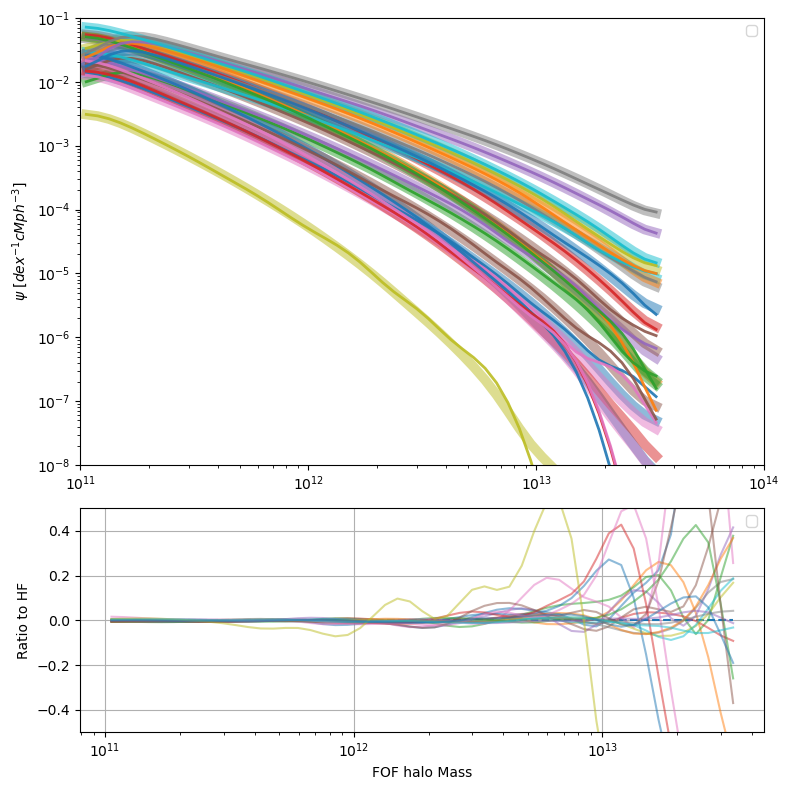

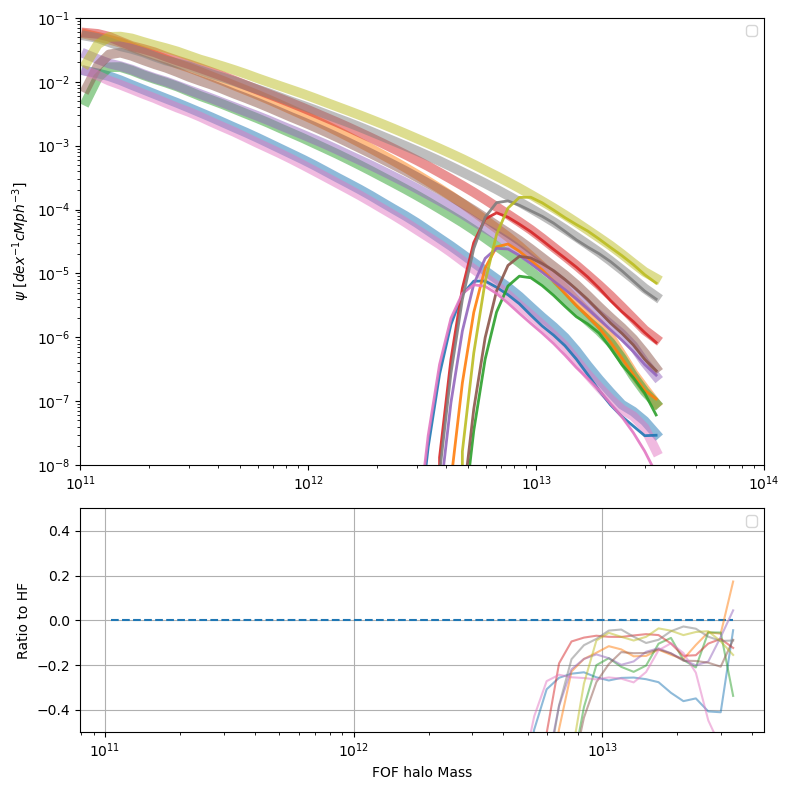

In [6]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.compare_fids(fids=['HF', 'L2'], sigma=2)
plt_hmf.compare_fids(fids=['HF', 'L1'], sigma=1)

01/09/2025 02:15:13 PM Found 21 common pairs
01/09/2025 02:15:13 PM Found 21 common pairs
01/09/2025 02:15:13 PM Found 21 common pairs
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
01/09/2025 02:15:14 PM Found 21 common pairs
01/09/2025 02:15:14 PM Found 21 common pairs
01/09/2025 02:15:14 PM Found 21 common pairs
No artists with labels found to put in legend.  Note that artists whose label start with an underscore

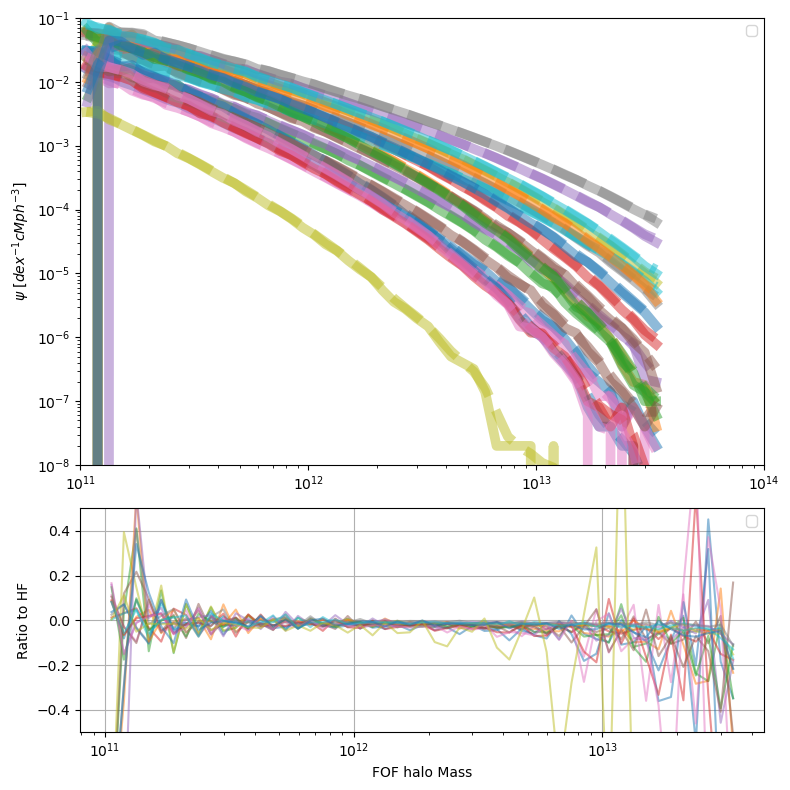

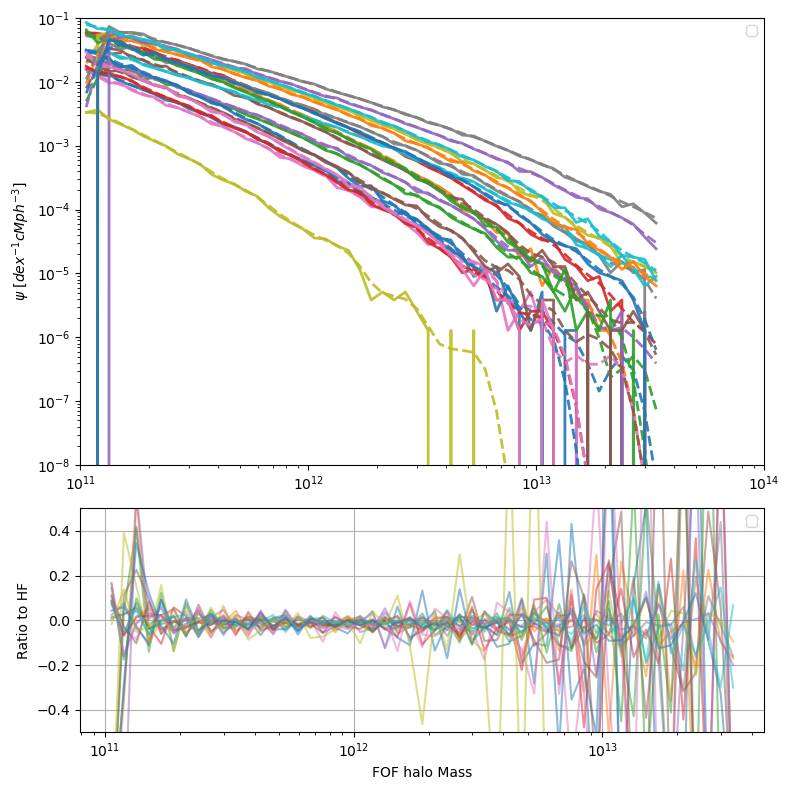

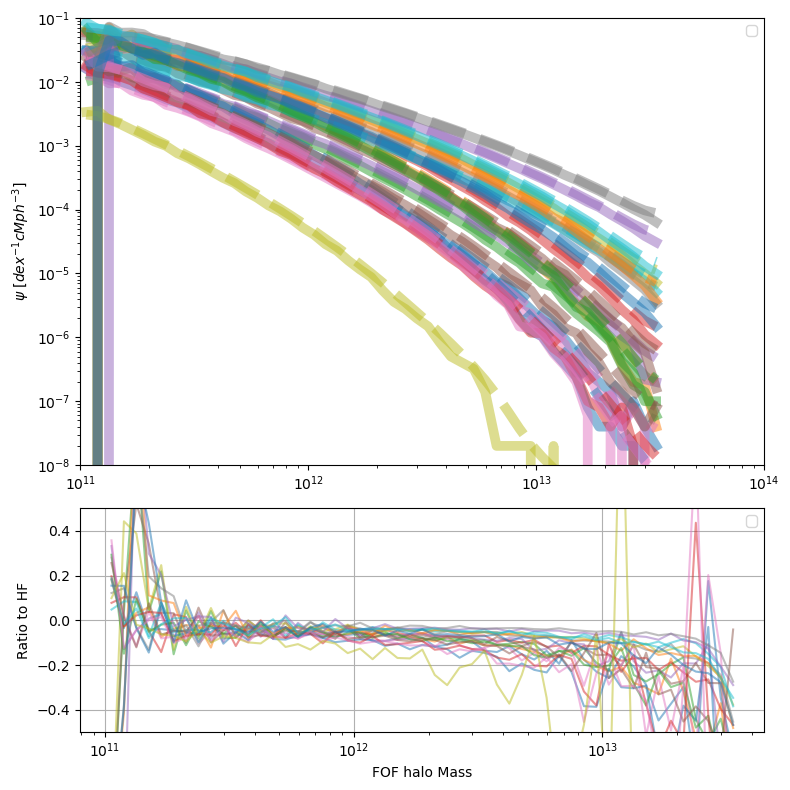

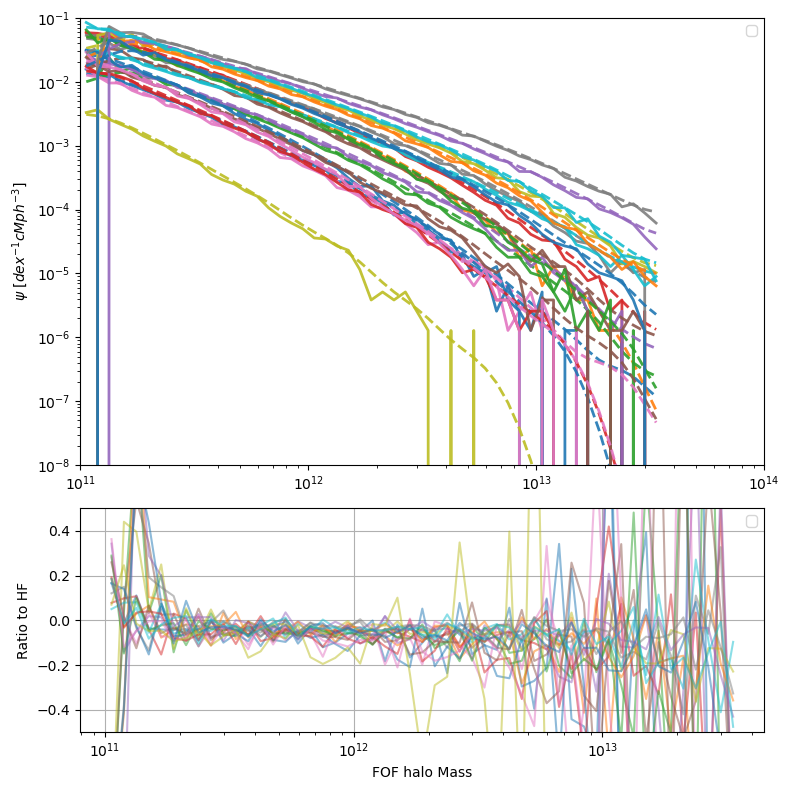

In [3]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.check_smoothed_hmf(fids=['HF', 'L2'], sigma=1)
plt_hmf.check_smoothed_hmf(fids=['HF', 'L2'], sigma=2)

# HMF Emu:

## Single fid on L2: